In [1]:
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties

from metpy.io import get_upper_air_data
from metpy.io.upperair import UseSampleData
from metpy.plots import Hodograph, SkewT
from metpy.calc import parcel_profile
import metpy.calc as mpcalc
import metpy.units as munit
from siphon.simplewebservice.wyoming import WyomingUpperAir

import seaborn as sns
import pygrib
import xarray as xr

font = FontProperties(fname='MicrosoftYaHei.ttf')

In [2]:
def get_values(variable, level):
    """获取 grib 文件中指定层的数据，并转换为xarray数组
    
    变量：
        variables :  读取后的数据
        level : 指定读取的层数
     
    返回：
        包含经纬度以及层数的数组
    """
    
    subs = []
    for sub in variable:
        subs.append(sub.values)
        
    lats, lons = sub.latlons()   
    
    return xr.DataArray(subs, 
                        coords=[level, lats[:, 0], lons[0, :]], 
                        dims=["level", "latitude", "longitude"])


def nearest_point(lon, lat, lons, lats):
    """获取最临近格点坐标
    
    parameters:
    ----------------------
    lon  : float
        指定点经度
    lat  : float
        指定点纬度
    lons : numpy.ndarray
        网格经度坐标. lons 的维度和大小要与 lats 一致
    lats : numpy.ndarray
        网格纬度坐标. lats 的维度和大小要与 lons 一致 
    
    Return:
    -----------------------
    longitude : float
    latitude : float
    
    """
    from scipy.spatial import cKDTree
    
    tree = cKDTree(np.array([lons.ravel(), lats.ravel()]).T)
    
    dis, indx = tree.query(np.array([lon, lat]), k=1)
    
    xidx, yidx = np.unravel_index(indx, lons.shape)
    
    return lons[xidx, yidx], lats[xidx, yidx]


def get_param_from_uwyo(dates, station, region = 'naconf'):
    """
    """
    
    import requests
    import re
#    from bs4 import BeautifulSoup
    
    url = ('http://weather.uwyo.edu/cgi-bin/sounding?region={region}&TYPE=TEXT%3ALIST'
            '&YEAR={time:%Y}&MONTH={time:%m}&FROM={time:%d%H}&TO={time:%d%H}'
            '&STNM={stid}').format(region=region, time=dates, stid=station)
    
    data = requests.request('get', url)
    
    cape = re.findall('(?<=Convective Available Potential Energy:)(.-?\d+\.\d+)', data.text)
    cin  = re.findall('(?<=Convective Inhibition:)(.-?\d+\.\d+)', data.text)
    tlcl = re.findall('(?<=Temp \[K\] of the Lifted Condensation Level:)(.-?\d+\.\d+)', data.text)
    plcl = re.findall('(?<=Pres \[hPa\] of the Lifted Condensation Level:)(.-?\d+\.\d+)', data.text)
    
    return(float(cape[0]), float(cin[0]), float(tlcl[0]), float(plcl[0]))

In [3]:
data = pygrib.open("fnl_20160623_06_00.grib2")

/usr/local/tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: MetpyDeprecationWarning: The get_upper_air_data function was deprecated in version 0.6. This function is being moved to the Siphon package.
/usr/local/tools/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


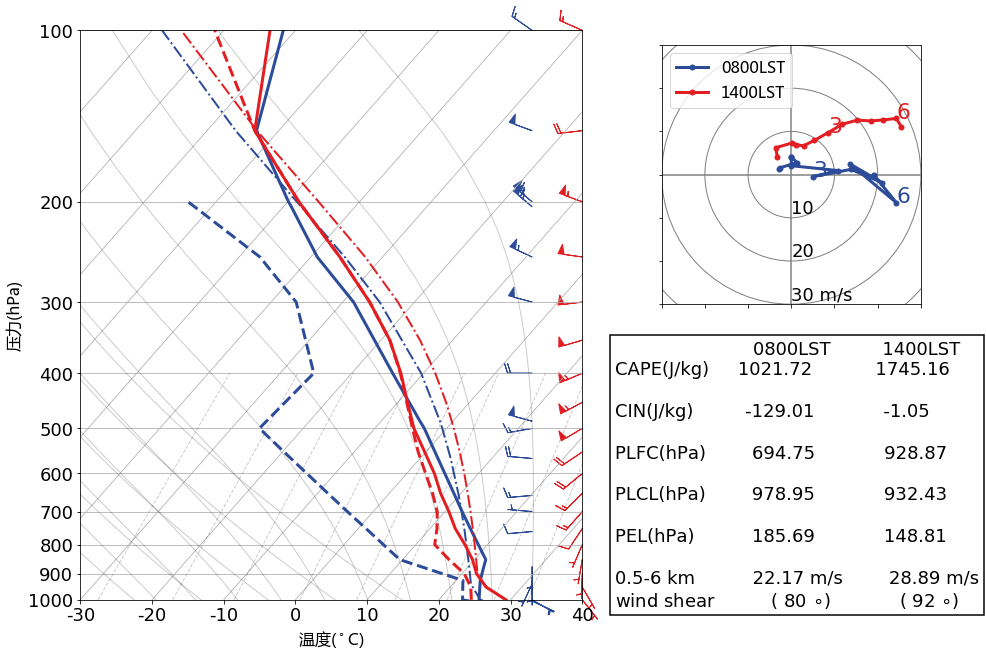

In [7]:
## 字体
font.set_size(16)

## 站点
dates = datetime(2016, 6, 23, 0)
station = 58150

## 图形参数
ft = 18
ld = 3
lds = 1
blue = np.array([44, 75, 152])/255
red = np.array([226, 30, 34])/255

tmin = -30
tmax = 40
ptop = 100
pbot = 1000
hodo = True

color = blue

## 获取指定日期和站点的探空数据
with UseSampleData():  # Only needed to use our local sample data
    # Download and parse the data
    dataset = get_upper_air_data(dates, station)

## sounding data
ind  = 19 
p0 = dataset.variables['pressure'][:ind]
T0 = dataset.variables['temperature'][:ind]
Td0 = dataset.variables['dewpoint'][:ind]
u0 = dataset.variables['u_wind'][:ind].to("m/s")
v0 = dataset.variables['v_wind'][:ind].to("m/s")
height0 = dataset.variables["height"][:]*munit.units.metre

## fnl reanalysis datas
level = np.arange(100, 1001, 50)
temps = get_values(data.select(name="Temperature", 
                               typeOfLevel="isobaricInhPa", 
                               level=level), 
                   level=level)
rh = get_values(data.select(name="Relative humidity", 
                            typeOfLevel="isobaricInhPa", 
                            level=level), 
                level=level)
uu = get_values(data.select(name="U component of wind", 
                            typeOfLevel="isobaricInhPa", 
                            level=level), 
                level=level)
vv = get_values(data.select(name="V component of wind", 
                            typeOfLevel="isobaricInhPa", 
                            level=level), 
                level=level)

lon = 119.8
lat = 33.78

Te = temps.sel(longitude=lon, latitude=lat, method="nearest")[::-1]
RH = rh.sel(longitude=lon, latitude=lat, method="nearest")[::-1]
U = uu.sel(longitude=lon, latitude=lat, method="nearest")[::-1]
V = vv.sel(longitude=lon, latitude=lat, method="nearest")[::-1]

P = np.arange(1000, 90, -50)
p1 = P*munit.units.millibar
T1 = (Te.values - 273.15)*munit.units.degC
Td1 = mpcalc.dewpoint_rh(T1, RH.values/100)
u1 = U.values * munit.units.metre/munit.units.second
v1 = V.values * munit.units.metre/munit.units.second
height1 = mpcalc.pressure_to_height_std(p1).to("m")

## 开始绘图
fig = plt.figure(figsize=(12, 9))

gs = gridspec.GridSpec(2, 3)

# Grid for plots
skew = SkewT(fig, rotation=45, subplot=gs[:, :2])

for p, T, Td, height, hind, u, v, color, loc, label in zip([p0, p1], [T0, T1], [Td0, Td1],
                                                     [height0, height1], [[7, 11], [6, 11]],
                                                     [u0, u1], [v0, v1], [blue, red], 
                                                     [0.9, 1.0], ["0800LST", "1400LST"]):
    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    # np.array([226, 30, 34])/255
    skew.plot(p, T, color=color, linestyle="-", linewidth=ld)
    skew.plot(p, Td, color=color, linestyle="--", linewidth=ld)
    skew.plot_barbs(p, u, v, color=color, xloc=loc, 
                    sizes=dict(emptybarb = 0), 
                    barb_increments=dict(half=5, full=10, flag=25))

    prof = parcel_profile(p, T[0], Td[0]).to('degC')
    skew.plot(p, prof, color=color, linewidth=ld-1, linestyle="-.")

#    skew.shade_cin(p, T, prof)
#    skew.shade_cape(p, T, prof)
    
    if hodo:
        if label == "0800LST":
            # Create a hodograph
#            ax = fig.add_subplot(gs[0, -1])
            ax = fig.add_axes([0.72, 0.55, 0.4, 0.4])
        #   ax_hod = inset_axes(skew.ax, '40%', '40%', loc = 3)
            ax.xaxis.set_ticklabels([])
            ax.yaxis.set_ticklabels([])
            
#            ax.set_position([0.7, 0.45, 0.3, 0.5])  
            
            ic = 10
            h = Hodograph(ax, component_range=30.)
            h.add_grid(increment=ic, linestyle="-") 
            
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.set_xlim([-30, 30])
            ax.set_ylim([-30, 30])
            
            ax.text(0, -0.9*ic, "10", fontdict=dict(fontsize=ft))
            ax.text(0, -1.9*ic, "20", fontdict=dict(fontsize=ft))
            ax.text(0, -2.9*ic, "30 m/s", fontdict=dict(fontsize=ft))
        
        ax.text(u[hind[0]].magnitude, v[hind[0]].magnitude, int(height[hind[0]].magnitude/1000), 
                fontdict=dict(fontsize=22, color=color))
        
        ax.text(u[hind[1]].magnitude, v[hind[1]].magnitude, int(height[hind[1]].magnitude/1000), 
                fontdict=dict(fontsize=22, color=color))
            
        h.plot(u[:13], v[:13], color=color, 
               linewidth=ld, 
               linestyle="-", 
               marker=".", 
               markersize=10,
               label=label)

ax.legend(loc=2, prop=font, fancybox=True, frameon=True) #bbox_to_anchor=(0.05, 0.88)
#ax.text(0.7, 0.05, "km AGL", transform=ax.transAxes, fontdict=dict(fontsize=ft))

# Add the relevant special lines
skew.plot_dry_adiabats(color="k", linestyle="-", alpha=0.2, linewidth=lds)
skew.plot_moist_adiabats(color="k", linestyle="-", alpha=0.2, linewidth=lds)
skew.plot_mixing_lines(p=np.array([1000, 400])*munit.units.millibar, color="k", linestyle="--", alpha=0.2, linewidth=lds)


sb_cape0, sb_cin0 = mpcalc.surface_based_cape_cin(p0, T0, Td0)
lcl_pressure0, lcl_temperature0 = mpcalc.lcl(p0[0], T0[0], Td0[0])
lfc_pressure0, lfc_temperature0 = mpcalc.lfc(p0, T0, Td0)
el_pressure0, el_temperature0 = mpcalc.el(p0, T0, Td0)

sb_cape, sb_cin = mpcalc.surface_based_cape_cin(p1, T1, Td1)
lcl_pressure, lcl_temperature = mpcalc.lcl(p1[0], T1[0], Td1[0])
lfc_pressure, lfc_temperature = mpcalc.lfc(p1, T1, Td1)
el_pressure, el_temperature = mpcalc.el(p1, T1, Td1)

#p_srh, n_srh, t_srh = mpcalc.storm_relative_helicity(u_wind, v_wind, pressure, height, depth=1*munit.units.km, bottom=height[0])
bulk_shear_u, bulk_shear_v = mpcalc.bulk_shear(p1, u1, v1, 
                                               bottom=0.5*munit.units.km, 
                                               depth=6*munit.units.km)

bulk_shear = mpcalc.get_wind_speed(bulk_shear_u, bulk_shear_v)
cape, cin, tlcl, plcl = get_param_from_uwyo(dates, station)

bulk_shear_u0, bulk_shear_v0 = mpcalc.bulk_shear(p0, u0, v0, bottom=0.5*munit.units.km, depth=6*munit.units.km)
bulk_shear0 = mpcalc.get_wind_speed(bulk_shear_u0, bulk_shear_v0)

atext =  "                        0800LST         1400LST\n"
atext += "CAPE(J/kg)    {0:^10.2f}        {7:^10.2f}\n\n"
atext += "CIN(J/kg)        {1:^10.2f}        {8:^10.2f}\n\n"
atext += "PLFC(hPa)      {2:^10.2f}        {9:^10.2f}\n\n"
atext += "PLCL(hPa)      {3:^10.2f}        {10:^10.2f}\n\n"
atext += "PEL(hPa)        {4:^10.2f}        {11:^10.2f}\n\n"
atext += "0.5-6 km          {5:^4.2f} m/s        {12:^4.2f} m/s\n"
atext += "wind shear          ({6:^4d}$\circ$)            ({13:^4d}$\circ$)"

angle0 = mpcalc.get_wind_dir(u0[11], v0[11]) - mpcalc.get_wind_dir(u0[2], v0[2])
angle1 = mpcalc.get_wind_dir(u1[11], v1[11]) - mpcalc.get_wind_dir(u1[1], v1[1])

atext = atext.format(sb_cape0.magnitude, sb_cin0.magnitude, 
                     lfc_pressure0.magnitude, lcl_pressure0.magnitude, 
                     el_pressure0.magnitude,
                     bulk_shear0.magnitude, int(angle0.magnitude),
                     sb_cape.magnitude, sb_cin.magnitude, 
                     lfc_pressure.magnitude, lcl_pressure.magnitude, 
                     el_pressure.magnitude,
                     bulk_shear.magnitude, int(angle1.magnitude))


# Good bounds for aspect ratio
# 获取 xticks 的值
xticks = skew.ax.get_xticks()
# 设置 xticks 值，间隔为 10，并转换数据类型为整型
xticks = np.arange(xticks.min(), xticks.max(), 10, dtype = np.integer)
# 设置坐标轴标记
skew.ax.set_xticks(xticks)
skew.ax.set_xticklabels(xticks, fontdict = dict(fontsize = ft))
skew.ax.set_yticks(np.arange(ptop, pbot + 1, 100))
skew.ax.set_yticklabels(np.arange(ptop, pbot + 1, 100), fontdict = dict(fontsize = ft))
# 设置坐标轴上下限
skew.ax.set_xlim(tmin, tmax)
skew.ax.set_ylim(pbot, ptop)
skew.ax.set_xlabel('温度($^\circ$C)', fontsize=ft, fontproperties=font)
skew.ax.set_ylabel('压力(hPa)', fontsize=ft, fontproperties=font)
   
ax = fig.add_subplot(gs[1, -1]) 

ax.text(0.03, 0.45, atext, 
        bbox=dict(edgecolor="black", facecolor="white", linewidth=1.5, pad=5), 
        backgroundcolor='white', 
        fontsize = ft, 
        color="k",
        verticalalignment='center', 
        horizontalalignment='left')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_axis_off()

plt.tight_layout()
# Show the plot
if 0:
    plt.savefig("20160623_skewt_imporvment.pdf", 
                dip = 1000, 
                bbox_inches = "tight")

plt.show()